In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('train_ver2.csv')

/Users/ryan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13647309 entries, 0 to 13647308
Data columns (total 48 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fecha_dato             object 
 1   ncodpers               int64  
 2   ind_empleado           object 
 3   pais_residencia        object 
 4   sexo                   object 
 5   age                    object 
 6   fecha_alta             object 
 7   ind_nuevo              float64
 8   antiguedad             object 
 9   indrel                 float64
 10  ult_fec_cli_1t         object 
 11  indrel_1mes            object 
 12  tiprel_1mes            object 
 13  indresi                object 
 14  indext                 object 
 15  conyuemp               object 
 16  canal_entrada          object 
 17  indfall                object 
 18  tipodom                float64
 19  cod_prov               float64
 20  nomprov                object 
 21  ind_actividad_cliente  float64
 22  renta           

# Initialize Spark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.sql.functions import udf
from pyspark.sql import functions as f
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

In [2]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("xor") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '1') \
    .config('spark.cores.max', '1') \
    .config("spark.driver.memory",'1g') \
    .getOrCreate()

sc = spark.sparkContext

# Import Data, Inspect Columns

In [3]:
traindf = spark.read.option("inferSchema", "true").csv('train_ver2.csv', header = True)

In [4]:
traindf.columns

['fecha_dato',
 'ncodpers',
 'ind_empleado',
 'pais_residencia',
 'sexo',
 'age',
 'fecha_alta',
 'ind_nuevo',
 'antiguedad',
 'indrel',
 'ult_fec_cli_1t',
 'indrel_1mes',
 'tiprel_1mes',
 'indresi',
 'indext',
 'conyuemp',
 'canal_entrada',
 'indfall',
 'tipodom',
 'cod_prov',
 'nomprov',
 'ind_actividad_cliente',
 'renta',
 'segmento',
 'ind_ahor_fin_ult1',
 'ind_aval_fin_ult1',
 'ind_cco_fin_ult1',
 'ind_cder_fin_ult1',
 'ind_cno_fin_ult1',
 'ind_ctju_fin_ult1',
 'ind_ctma_fin_ult1',
 'ind_ctop_fin_ult1',
 'ind_ctpp_fin_ult1',
 'ind_deco_fin_ult1',
 'ind_deme_fin_ult1',
 'ind_dela_fin_ult1',
 'ind_ecue_fin_ult1',
 'ind_fond_fin_ult1',
 'ind_hip_fin_ult1',
 'ind_plan_fin_ult1',
 'ind_pres_fin_ult1',
 'ind_reca_fin_ult1',
 'ind_tjcr_fin_ult1',
 'ind_valo_fin_ult1',
 'ind_viv_fin_ult1',
 'ind_nomina_ult1',
 'ind_nom_pens_ult1',
 'ind_recibo_ult1']

The columns are in Spanish and are a little bit vague. I'm going to rename all of them (except for age :))

In [5]:
traindf = traindf.withColumnRenamed("fecha_dato", "Date")\
    .withColumnRenamed("ncodpers", "Customer_Code")\
    .withColumnRenamed("ind_empleado", "Employment_Index")\
    .withColumnRenamed("pais_residencia", "Country_Residence")\
    .withColumnRenamed("fecha_alta", "Join_Date")\
    .withColumnRenamed("ind_nuevo", "New_customer")\
    .withColumnRenamed("sexo", "Gender")\
    .withColumnRenamed("canal_entrada", "Channel")\
    .withColumnRenamed("antiguedad", "Months_at_Bank")\
    .withColumnRenamed("indrel", "Customer_during_Month")\
    .withColumnRenamed("ult_fec_cli_1t", "Stopped_Being_Customer")\
    .withColumnRenamed("indrel_1mes", "Customer_Type")\
    .withColumnRenamed("tiprel_1mes", "Relationship_to_Bank")\
    .withColumnRenamed("indresi", "Residence_Index")\
    .withColumnRenamed("indext", "Foreigner_Index")\
    .withColumnRenamed("conyuemp", "Spouse_Index")\
    .withColumnRenamed("indfall", "Deceased_Index")\
    .withColumnRenamed("tipodom", "Address_Type")\
    .withColumnRenamed("cod_prov", "Province_Code")\
    .withColumnRenamed("nomprov", "Province_Name")\
    .withColumnRenamed("ind_actividad_cliente", "Active")\
    .withColumnRenamed("renta", "Income")\
    .withColumnRenamed("segmento", "Segmentation")\
    .withColumnRenamed("ind_ahor_fin_ult1", "Savings_Account")\
    .withColumnRenamed("ind_aval_fin_ult1", "Guarantees")\
    .withColumnRenamed("ind_cco_fin_ult1", "Current_Accounts")\
    .withColumnRenamed("ind_cder_fin_ult1", "Derivative")\
    .withColumnRenamed("ind_cno_fin_ult1", "Payroll_Account")\
    .withColumnRenamed("ind_ctju_fin_ult1", "Junior_Account")\
    .withColumnRenamed("ind_ctma_fin_ult1", "More_Particular_Account")\
    .withColumnRenamed("ind_ctop_fin_ult1", "Particular_Account")\
    .withColumnRenamed("ind_ctpp_fin_ult1", "Particular_Plus_Account")\
    .withColumnRenamed("ind_deco_fin_ult1", "Short_Term_Deposits")\
    .withColumnRenamed("ind_deme_fin_ult1", "Medium_Term_Deposits")\
    .withColumnRenamed("ind_dela_fin_ult1", "Long_Term_Deposits")\
    .withColumnRenamed("ind_ecue_fin_ult1", "e-Account")\
    .withColumnRenamed("ind_fond_fin_ult1", "Funds")\
    .withColumnRenamed("ind_hip_fin_ult1", "Mortgage")\
    .withColumnRenamed("ind_plan_fin_ult1", "Pensions")\
    .withColumnRenamed("ind_pres_fin_ult1", "Loans")\
    .withColumnRenamed("ind_reca_fin_ult1", "Taxes")\
    .withColumnRenamed("ind_tjcr_fin_ult1", "Credit_Card")\
    .withColumnRenamed("ind_valo_fin_ult1", "Securities")\
    .withColumnRenamed("ind_viv_fin_ult1", "Home_Account")\
    .withColumnRenamed("ind_nomina_ult1", "Payroll")\
    .withColumnRenamed("ind_nom_pens_ult1", "Pensions_two")\
    .withColumnRenamed("ind_recibo_ult1", "Direct_Debit")
traindf.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Customer_Code: double (nullable = true)
 |-- Employment_Index: string (nullable = true)
 |-- Country_Residence: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- Join_Date: string (nullable = true)
 |-- New_customer: string (nullable = true)
 |-- Months_at_Bank: string (nullable = true)
 |-- Customer_during_Month: string (nullable = true)
 |-- Stopped_Being_Customer: string (nullable = true)
 |-- Customer_Type: string (nullable = true)
 |-- Relationship_to_Bank: string (nullable = true)
 |-- Residence_Index: string (nullable = true)
 |-- Foreigner_Index: string (nullable = true)
 |-- Spouse_Index: string (nullable = true)
 |-- Channel: string (nullable = true)
 |-- Deceased_Index: string (nullable = true)
 |-- Address_Type: string (nullable = true)
 |-- Province_Code: string (nullable = true)
 |-- Province_Name: string (nullable = true)
 |-- Active: string (nullable = true)
 |-- Income: d

In [6]:
testdf = spark.read.option("inferSchema", "true").csv('test_ver2.csv', header = True)

In [7]:
testdf.columns

['fecha_dato',
 'ncodpers',
 'ind_empleado',
 'pais_residencia',
 'sexo',
 'age',
 'fecha_alta',
 'ind_nuevo',
 'antiguedad',
 'indrel',
 'ult_fec_cli_1t',
 'indrel_1mes',
 'tiprel_1mes',
 'indresi',
 'indext',
 'conyuemp',
 'canal_entrada',
 'indfall',
 'tipodom',
 'cod_prov',
 'nomprov',
 'ind_actividad_cliente',
 'renta',
 'segmento']

In [8]:
testdf = testdf.withColumnRenamed("fecha_dato", "Date")\
    .withColumnRenamed("ncodpers", "Customer_Code")\
    .withColumnRenamed("ind_empleado", "Employment_Index")\
    .withColumnRenamed("pais_residencia", "Country_Residence")\
    .withColumnRenamed("fecha_alta", "Join_Date")\
    .withColumnRenamed("ind_nuevo", "New_customer")\
    .withColumnRenamed("sexo", "Gender")\
    .withColumnRenamed("canal_entrada", "Channel")\
    .withColumnRenamed("antiguedad", "Months_at_Bank")\
    .withColumnRenamed("indrel", "Customer_during_Month")\
    .withColumnRenamed("ult_fec_cli_1t", "Stopped_Being_Customer")\
    .withColumnRenamed("indrel_1mes", "Customer_Type")\
    .withColumnRenamed("tiprel_1mes", "Relationship_to_Bank")\
    .withColumnRenamed("indresi", "Residence_Index")\
    .withColumnRenamed("indext", "Foreigner_Index")\
    .withColumnRenamed("conyuemp", "Spouse_Index")\
    .withColumnRenamed("indfall", "Deceased_Index")\
    .withColumnRenamed("tipodom", "Address_Type")\
    .withColumnRenamed("cod_prov", "Province_Code")\
    .withColumnRenamed("nomprov", "Province_Name")\
    .withColumnRenamed("ind_actividad_cliente", "Active")\
    .withColumnRenamed("renta", "Income")\
    .withColumnRenamed("segmento", "Segmentation")
testdf.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Customer_Code: double (nullable = true)
 |-- Employment_Index: string (nullable = true)
 |-- Country_Residence: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- Join_Date: string (nullable = true)
 |-- New_customer: integer (nullable = true)
 |-- Months_at_Bank: double (nullable = true)
 |-- Customer_during_Month: double (nullable = true)
 |-- Stopped_Being_Customer: string (nullable = true)
 |-- Customer_Type: double (nullable = true)
 |-- Relationship_to_Bank: string (nullable = true)
 |-- Residence_Index: string (nullable = true)
 |-- Foreigner_Index: string (nullable = true)
 |-- Spouse_Index: string (nullable = true)
 |-- Channel: string (nullable = true)
 |-- Deceased_Index: string (nullable = true)
 |-- Address_Type: integer (nullable = true)
 |-- Province_Code: string (nullable = true)
 |-- Province_Name: string (nullable = true)
 |-- Active: integer (nullable = true)
 |-- Income

Some of the feature columns appear to be redundant:

testdf.groupBy('Province_Code').count().orderBy('count').show()


In [9]:
testdf.groupBy('Province_Name').count().orderBy('count').show()

+--------------------+-----+
|       Province_Name|count|
+--------------------+-----+
|               CEUTA|  513|
|             MELILLA|  643|
|               SORIA| 1261|
|              TERUEL| 1538|
|               ALAVA| 2591|
|               AVILA| 2628|
|              HUESCA| 2789|
|             SEGOVIA| 2881|
|            PALENCIA| 3311|
|              ZAMORA| 3430|
|              CUENCA| 3788|
|                null| 3996|
|             ALMERIA| 4307|
|                JAEN| 4496|
|         GUADALAJARA| 4678|
|            GIPUZKOA| 4869|
|SANTA CRUZ DE TEN...| 5097|
|              LERIDA| 5430|
|             OURENSE| 5605|
|                LUGO| 5656|
+--------------------+-----+
only showing top 20 rows



In [10]:
traindf = traindf.drop(traindf.Province_Code)

testdf = testdf.drop(testdf.Province_Code) 

Residence_Index and Foreigner_Index are inverses of each other; we don't need both

In [11]:
traindf = traindf.drop(traindf.Residence_Index) 

testdf = testdf.drop(testdf.Residence_Index) 


Inspect the data for NANs and Null values:

In [12]:
from pyspark.sql.functions import isnan, when, count, col

traindf.select([count(when(col(c).isNull(), c)).alias(c) for c in 
           traindf.columns]).toPandas().T


,0
Date,0
Customer_Code,0
Employment_Index,27734
Country_Residence,27734
Gender,27804
age,0
Join_Date,27734
New_customer,0
Months_at_Bank,0
Customer_during_Month,0


In [13]:
testdf.select([count(when(col(c).isNull(), c)).alias(c) for c in 
           testdf.columns]).toPandas().T

,0
Date,0
Customer_Code,0
Employment_Index,0
Country_Residence,0
Gender,5
age,0
Join_Date,0
New_customer,0
Months_at_Bank,0
Customer_during_Month,0


The good news is that there are no NAN values, and that there are no null values for any of the product columns. The bad news is that 15 of the 22 feature columns in the training set, and 8 of the 22 feature columns in the test set have null values.

 ##  Highlighting Certain Columns, and Imputing Values

#### Customer_Code 

In [76]:
ccgroup = traindf.groupBy('Customer_Code').count()
traindf.groupBy('Customer_Code').count().show()

+-------------+-----+
|Customer_Code|count|
+-------------+-----+
|    1050599.0|   17|
|    1052358.0|   10|
|    1052187.0|   17|
|    1048934.0|   15|
|    1048839.0|   17|
|    1049108.0|   17|
|    1048792.0|   17|
|    1048656.0|   17|
|    1049799.0|   17|
|    1049905.0|   17|
|    1049944.0|   17|
|    1056294.0|   17|
|    1055185.0|   17|
|    1055633.0|   17|
|    1055721.0|   17|
|    1055528.0|   17|
|    1056869.0|   17|
|    1056843.0|   17|
|    1056723.0|   17|
|    1056566.0|   17|
+-------------+-----+
only showing top 20 rows



In [83]:
testdf.filter(testdf.Customer_Code == "1048934.0").show(truncate=False)

+----------+-------------+----------------+------+----+--------------+---------------------+-------------+---------------+-------+--------------+------------+-------------+------+-----------+------------------+
|Date      |Customer_Code|Employment_Index|Gender|age |Months_at_Bank|Customer_during_Month|Customer_Type|Foreigner_Index|Channel|Deceased_Index|Address_Type|Province_Name|Active|Income     |Segmentation      |
+----------+-------------+----------------+------+----+--------------+---------------------+-------------+---------------+-------+--------------+------------+-------------+------+-----------+------------------+
|2016-06-28|1048934.0    |N               |V     |24.0|46.0          |1.0                  |1.0          |N              |KHE    |N             |1           |ZARAGOZA     |0     |   55545.48|03 - UNIVERSITARIO|
+----------+-------------+----------------+------+----+--------------+---------------------+-------------+---------------+-------+--------------+-----------

Each individual customer has up to 17 observations, which coincides with the 17 months that the dataset measures. 

#### Employment_Index

In [15]:
traindf.groupBy('Employment_Index').count().show()

+----------------+--------+
|Employment_Index|   count|
+----------------+--------+
|               F|    2523|
|            null|   27734|
|               B|    3566|
|               A|    2492|
|               N|13610977|
|               S|      17|
+----------------+--------+



In [16]:
##Impute Highest Frequency Value
traindf = traindf.na.fill(value='N',subset=["Employment_Index"])

#### Country_Residence

In [17]:
traindf.groupBy('Country_Residence').count().orderBy(col("count").desc()).show()

+-----------------+--------+
|Country_Residence|   count|
+-----------------+--------+
|               ES|13553710|
|             null|   27734|
|               FR|    5161|
|               AR|    4835|
|               DE|    4625|
|               GB|    4605|
|               US|    3651|
|               CO|    3526|
|               IT|    2947|
|               RO|    2931|
|               MX|    2573|
|               BR|    2351|
|               VE|    2331|
|               EC|    2169|
|               CH|    1995|
|               BE|    1526|
|               BO|    1514|
|               PY|    1430|
|               PT|    1419|
|               CL|     989|
+-----------------+--------+
only showing top 20 rows



In [18]:
##Not enough values in non-Spain Countries to justify this column. Will use 'Foreigner Index' instead
traindf = traindf.drop(traindf.Country_Residence) 

testdf = testdf.drop(testdf.Country_Residence) 

#### Gender (Ask about whether appropriate to delete rows)

In [19]:
traindf.groupBy('Gender').count().orderBy(col("count").desc()).show()

+------+-------+
|Gender|  count|
+------+-------+
|     V|7424252|
|     H|6195253|
|  null|  27804|
+------+-------+



In [86]:
from pyspark.sql.functions import regexp_replace
traindf = traindf.withColumn('Gender', regexp_replace('Gender', 'V', 'Female'))
traindf = traindf.withColumn('Gender', regexp_replace('Gender', 'H', 'Male'))
testdf = testdf.withColumn('Gender', regexp_replace('Gender', 'V', 'Female'))
testdf = testdf.withColumn('Gender', regexp_replace('Gender', 'H', 'Male'))

#### Age

In [20]:
traindf.groupBy('age').count().orderBy(col("age").desc()).show()

+---+-----+
|age|count|
+---+-----+
|164|    3|
|163|    8|
|127|    8|
|126|    3|
|117|   14|
|116|   63|
|115|   82|
|114|   22|
|113|  117|
|112|  188|
|111|  252|
|110|  261|
|109|  265|
|108|  456|
|107|  594|
|106|  899|
|105| 1280|
|104| 1350|
|103| 2003|
|102| 2335|
+---+-----+
only showing top 20 rows



In [21]:
###Bin Age into groups
#def Age(age):
 #   if   age<13: return '0-12'
  #  elif age>12 and age<18: return '13-17'
   # elif age>17 and age<25: return '18-24'
    #elif age>24 and age<41: return '25-40'
    #elif age>40 and age<66: return '41-65'
    #elif age>65 : return '66+'
#udf_Age = udf(Age, StringType())
#traindf = traindf.withColumn("Age", udf_Age('age'))

#### Join Date

In [22]:
traindf.groupBy('Join_Date').count().orderBy(col("count").desc()).show()

+----------+-----+
| Join_Date|count|
+----------+-----+
|2014-07-28|57389|
|2014-10-03|54287|
|2014-08-04|45746|
|2013-10-14|40804|
|2013-08-03|33414|
|      null|27734|
|2012-08-06|26223|
|2014-07-21|26027|
|2012-08-03|25409|
|2012-08-02|25004|
|2013-10-11|24751|
|2013-08-10|23766|
|2012-08-01|22935|
|2014-09-17|22810|
|2014-08-06|22756|
|2014-09-24|22696|
|2014-07-30|22695|
|2012-08-09|22433|
|2013-07-22|22309|
|2012-08-07|22052|
+----------+-----+
only showing top 20 rows



In [23]:
##Seems like it won't be a great predictive factor.Other variables measure how long someone has been at the bank
traindf = traindf.drop(traindf.Join_Date) 

testdf = testdf.drop(testdf.Join_Date) 

# 

#### New_customer

In [24]:
traindf.groupBy('New_customer').count().orderBy(col("count").desc()).show()

+------------+--------+
|New_customer|   count|
+------------+--------+
|           0|12808368|
|           1|  811207|
|          NA|   27734|
+------------+--------+



In [25]:
#Will stick with the Months_at_Bank feature for now
traindf = traindf.drop(traindf.New_customer) 

testdf = testdf.drop(testdf.New_customer) 

#### Spouse_Index 

In [26]:
traindf.groupBy('Spouse_Index').count().orderBy(col("count").desc()).show()

+------------+--------+
|Spouse_Index|   count|
+------------+--------+
|        null|13645501|
|           N|    1791|
|           S|      17|
+------------+--------+



In [27]:
#Almost entirely null values
traindf = traindf.drop(traindf.Spouse_Index) 

testdf = testdf.drop(testdf.Spouse_Index) 

In [28]:
traindf = traindf.drop(traindf.Stopped_Being_Customer) 

testdf = testdf.drop(testdf.Stopped_Being_Customer) 

#### Channel (not sure what to do with null values) 

In [29]:
traindf.groupBy('Channel').count().orderBy(col("count").desc()).show()

+-------+-------+
|Channel|  count|
+-------+-------+
|    KHE|4055270|
|    KAT|3268209|
|    KFC|3098360|
|    KHQ| 591039|
|    KFA| 409669|
|    KHK| 241084|
|   null| 186126|
|    KHM| 183924|
|    KHD| 116891|
|    KHN| 116608|
|    KAS|  86221|
|    RED|  75607|
|    KAG|  74295|
|    KAY|  67350|
|    KAA|  66656|
|    KAB|  62381|
|    KAE|  50764|
|    KCC|  49308|
|    KBZ|  46446|
|    KHL|  45128|
+-------+-------+
only showing top 20 rows



#### Customer_Type 

In [30]:
traindf.groupBy('Customer_Type').count().orderBy(col("count").desc()).show()

+-------------+-------+
|Customer_Type|  count|
+-------------+-------+
|          1.0|9133383|
|            1|4357298|
|         null| 149781|
|          3.0|   2780|
|            3|   1570|
|            P|    874|
|          2.0|    740|
|            2|    577|
|          4.0|    223|
|            4|     83|
+-------------+-------+



#### Relationship_to_Bank 

In [31]:
traindf.groupBy('Relationship_to_Bank').count().orderBy(col("count").desc()).show()

+--------------------+-------+
|Relationship_to_Bank|  count|
+--------------------+-------+
|                   I|7304875|
|                   A|6187123|
|                null| 149781|
|                   P|   4656|
|                   R|    870|
|                   N|      4|
+--------------------+-------+



In [32]:
##Active Index is a better metric
traindf = traindf.drop(traindf.Relationship_to_Bank) 

testdf = testdf.drop(testdf.Relationship_to_Bank) 

#### Foreigner_Index 

In [33]:
traindf.groupBy('Foreigner_Index').count().orderBy(col("count").desc()).show()

+---------------+--------+
|Foreigner_Index|   count|
+---------------+--------+
|              N|12974839|
|              S|  644736|
|           null|   27734|
+---------------+--------+



In [34]:
##Impute Highest Frequency Value
traindf = traindf.na.fill(value='N',subset=["Foreigner_Index"])

#### Address_Type 

In [35]:
traindf.groupBy('Address_Type').count().orderBy(col("count").desc()).show()

+------------+--------+
|Address_Type|   count|
+------------+--------+
|           1|13619574|
|          NA|   27735|
+------------+--------+



In [36]:
## Impute 0
traindf = traindf.na.fill(value=0 ,subset=["Address_Type"])
testdf = testdf.na.fill(value=0 ,subset=["Address_Type"])

#### Active 

In [37]:
traindf.groupBy('Active').count().orderBy(col("count").desc()).show()

+------+-------+
|Active|  count|
+------+-------+
|     0|7384390|
|     1|6235185|
|    NA|  27734|
+------+-------+



In [38]:
traindf = traindf.na.fill(value=0 ,subset=["Active"])
testdf = testdf.na.fill(value=0 ,subset=["Active"])

#### Income 

In [91]:
traindf.groupBy('Income').count().orderBy(col("Income").desc()).show()

+--------------------+-----+
|              Income|count|
+--------------------+-----+
|       2.889439551E7|   75|
|       2.554725192E7|   17|
|       2.425323693E7|   28|
|       2.372006655E7|   45|
|       2.203473876E7|   96|
|        2.17241865E7|   11|
|       2.167424667E7|   26|
|       1.984933197E7|   17|
|        1.78040481E7|   17|
|       1.601867784E7|   17|
|       1.595737164E7|   17|
|       1.571171646E7|   55|
|1.4337025919999998E7|   11|
|       1.326862128E7|   68|
|       1.190087151E7|   17|
|       1.185785646E7|   34|
|       1.180401498E7|   17|
|       1.141151727E7|   84|
|       1.138152603E7|   11|
|       1.134115248E7|   51|
+--------------------+-----+
only showing top 20 rows



TypeError: 'Column' object is not callable

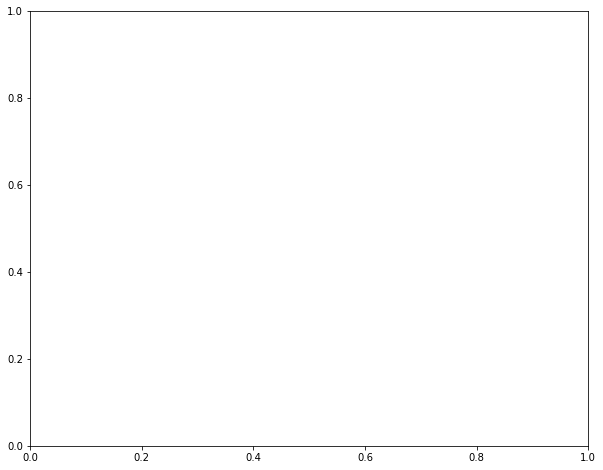

In [93]:
import numpy as np
var = 'Income'
x = traindf[var]
bins = np.arange(0, 30000000, 1500000)

plt.figure(figsize=(10,8))
# the histogram of the data
plt.hist(x, bins, alpha=0.8, histtype='bar', color='gold',
         ec='black',weights=np.zeros_like(x) + 100. / x.size)

plt.xlabel(var)
plt.ylabel('percentage')
plt.xticks(bins)
plt.show()

In [40]:
###Bin Income into groups
#def Income(Income):
 #   if   Income<13: return '0-12'
  #  elif age>12 and age<18: return '13-17'
   # elif age>17 and age<25: return '18-24'
    #elif age>24 and age<41: return '25-40'
    #elif age>40 and age<66: return '41-65'
    #elif age>65 : return '66+'
#udf_Age = udf(Age, StringType())
#traindf = traindf.withColumn("Age", udf_Age('age'))

#### Segmentation 

In [41]:
traindf.groupBy('Segmentation').count().orderBy(col("count")).show()

+------------------+-------+
|      Segmentation|  count|
+------------------+-------+
|              null| 189368|
|          01 - TOP| 562142|
|03 - UNIVERSITARIO|4935579|
| 02 - PARTICULARES|7960220|
+------------------+-------+



In [42]:
traindf = traindf.na.fill(value=0 ,subset=["Segmentation"])
testdf = testdf.na.fill(value=0 ,subset=["Segmentation"])

In [43]:
traindf.columns

['Date',
 'Customer_Code',
 'Employment_Index',
 'Gender',
 'age',
 'Months_at_Bank',
 'Customer_during_Month',
 'Customer_Type',
 'Foreigner_Index',
 'Channel',
 'Deceased_Index',
 'Address_Type',
 'Province_Name',
 'Active',
 'Income',
 'Segmentation',
 'Savings_Account',
 'Guarantees',
 'Current_Accounts',
 'Derivative',
 'Payroll_Account',
 'Junior_Account',
 'More_Particular_Account',
 'Particular_Account',
 'Particular_Plus_Account',
 'Short_Term_Deposits',
 'Medium_Term_Deposits',
 'Long_Term_Deposits',
 'e-Account',
 'Funds',
 'Mortgage',
 'Pensions',
 'Loans',
 'Taxes',
 'Credit_Card',
 'Securities',
 'Home_Account',
 'Payroll',
 'Pensions_two',
 'Direct_Debit']

#### Payroll 

In [69]:
traindf.groupBy('Payroll').count().orderBy(col("count")).show()

+-------+--------+
|Payroll|   count|
+-------+--------+
|     NA|   16063|
|      1|  745961|
|      0|12885285|
+-------+--------+



In [70]:
traindf = traindf.na.fill(value=0 ,subset=["Payroll"])

#### Pensions_two 

In [71]:
traindf.groupBy('Pensions_two').count().orderBy(col("count")).show()

+------------+--------+
|Pensions_two|   count|
+------------+--------+
|          NA|   16063|
|           1|  810085|
|           0|12821161|
+------------+--------+



In [72]:
traindf = traindf.na.fill(value=0 ,subset=["Pensions_two"])

# EDA 